## Exercise 1

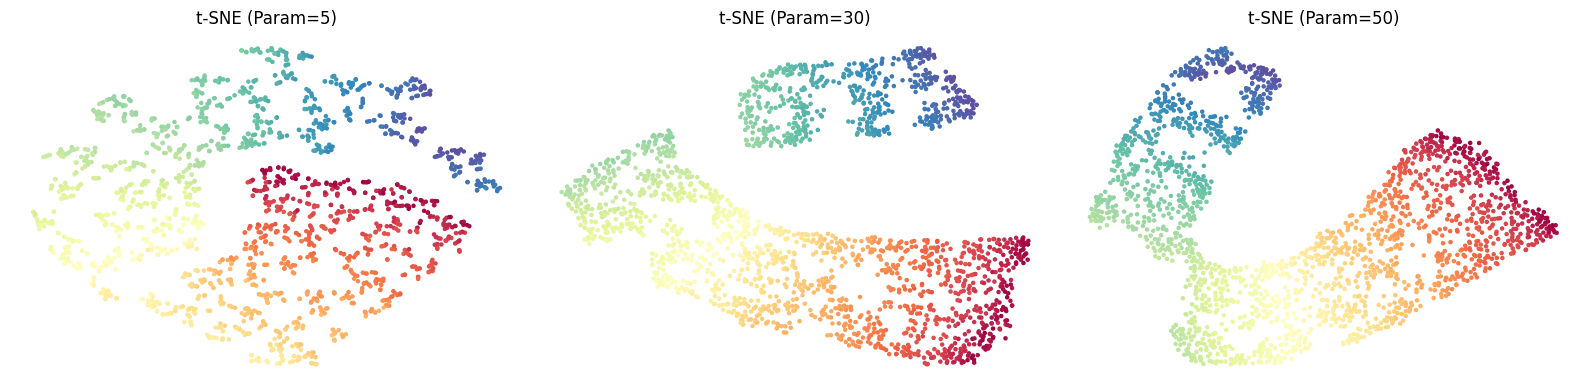

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import TSNE
#import umap

# Step 1: Generate a synthetic dataset (Swiss Roll with noise)
np.random.seed(42)
data, colors = make_swiss_roll(n_samples=2000, noise=0.1)
# Add 10 extra random dimensions to make it complex
extra_dims = np.random.normal(size=(data.shape[0], 10))
data_high_dim = np.hstack([data, extra_dims])

# Step 2: Initialize hyperparameters for t-SNE and UMAP
tsne_perplexities = [5, 30, 50]
#umap_n_neighbors = [5, 15, 50]

# Step 3: Apply t-SNE and UMAP with different hyperparameters and collect results
tsne_results = {p: TSNE(n_components=2, perplexity=p, random_state=42).fit_transform(data_high_dim)
                for p in tsne_perplexities}
#umap_results = {n: umap.UMAP(n_neighbors=n, random_state=42).fit_transform(data_high_dim)
#                for n in umap_n_neighbors}

# Plotting helper function
def plot_results(results, title, colors):
    plt.figure(figsize=(16, 4))
    for i, (param, embedding) in enumerate(results.items(), 1):
        plt.subplot(1, len(results), i)
        plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='Spectral', s=5)
        plt.title(f"{title} (Param={param})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Step 4: Visualize results
plot_results(tsne_results, "t-SNE", colors)
#plot_results(umap_results, "UMAP", colors)


## Exercise 2

Running clustering on blob dataset...


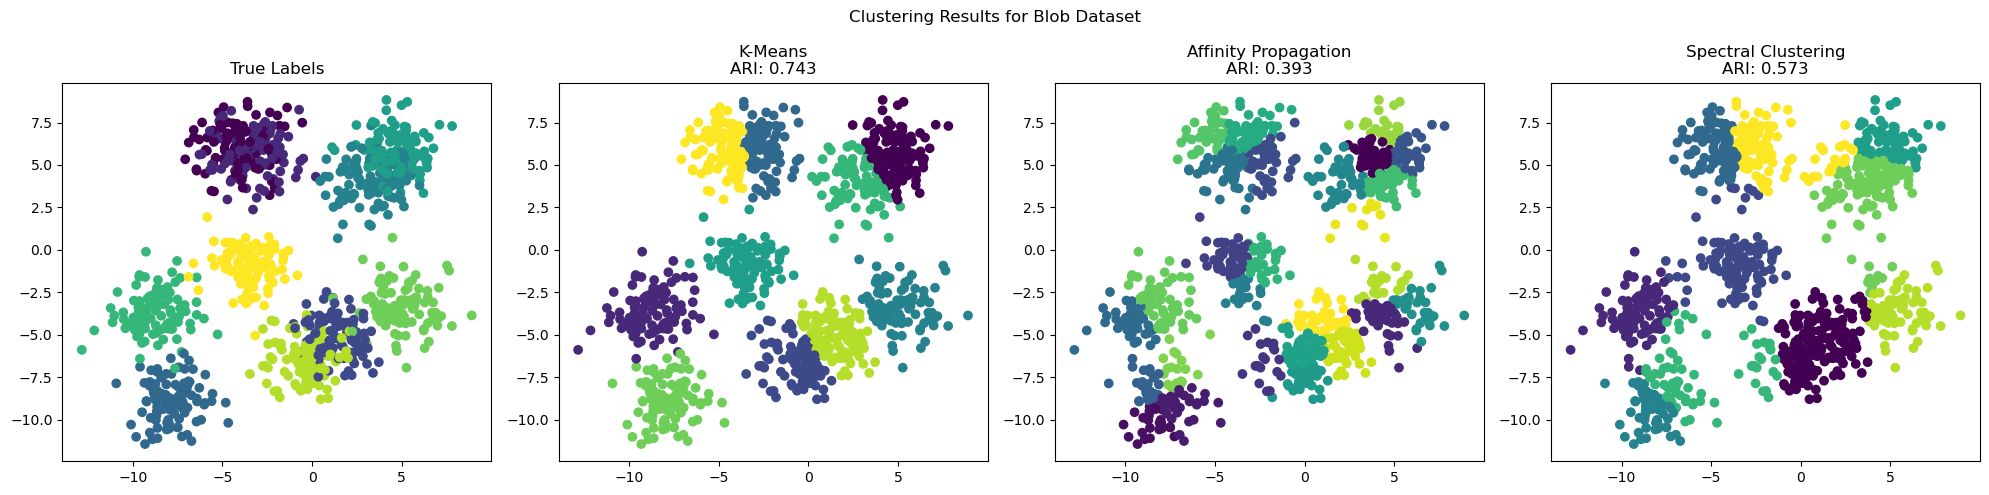


Evaluation metrics for Blob Dataset:
----------------------------------------
K-Means ARI: 0.743
Affinity Propagation ARI: 0.393
Spectral Clustering ARI: 0.573
Number of clusters found - AP: 27

Running clustering on checkerboard dataset...


/Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


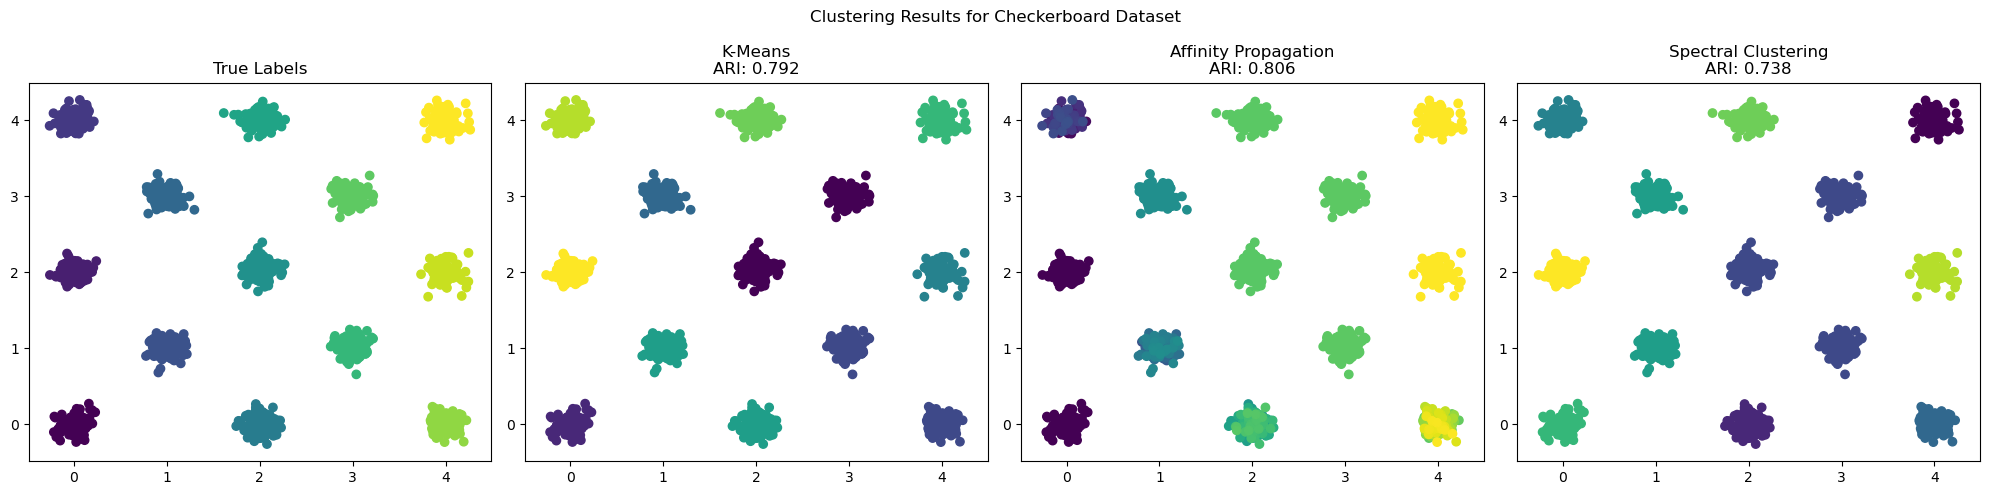


Evaluation metrics for Checkerboard Dataset:
----------------------------------------
K-Means ARI: 0.792
Affinity Propagation ARI: 0.806
Spectral Clustering ARI: 0.738
Number of clusters found - AP: 408


In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering

n_clusters = 10

# Create the 2 datasets
X, y = make_blobs(n_samples=1000, centers=n_clusters, cluster_std=1.2, random_state=69)

def generate_checkerboard_data(n_samples, n_clusters, blocks, noise=0.1):
    samples_per_cluster = n_samples // n_clusters
    X = []
    y = []
    temp = 0
    for i in range(blocks):
        for j in range(blocks):
            if (i + j) % 2 == 0:
                x = np.random.normal(i * 1, noise, samples_per_cluster)
                y_coord = np.random.normal(j * 1, noise, samples_per_cluster)

                X.extend(list(zip(x, y_coord)))
                y.extend([temp] * samples_per_cluster)
                temp += 1
    return np.array(X), np.array(y)

X2, y2 = generate_checkerboard_data(1000, n_clusters, 5)

def transform_for_model(X, modelname):
    if modelname == "k-means":
        scaler = StandardScaler()
        X_transformed = scaler.fit_transform(X)
        return X_transformed
    elif modelname == "spectral" or modelname == "affinity":
        # Compute RBF kernel similarity matrix for both Spectral and Affinity
        gamma = 1.0 / (X.shape[1] * X.var())
        similarity_matrix = rbf_kernel(X, gamma=gamma)

        if modelname == "affinity":
            # Scale similarities for Affinity Propagation
            similarity_matrix = -50 * (1 - similarity_matrix)

        return similarity_matrix

# Function to run clustering on both datasets
def run_clustering(X, y, dataset_name):
    # Transform data for each algorithm
    X_kmeans = transform_for_model(X, "k-means")
    X_affinity = transform_for_model(X, "affinity")
    X_spectral = transform_for_model(X, "spectral")

    # Perform clustering
    # K-means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=69)
    kmeans_labels = kmeans.fit_predict(X_kmeans)

    # Affinity Propagation
    affin = AffinityPropagation(random_state=69, affinity='precomputed')
    affin_labels = affin.fit_predict(X_affinity)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=69)
    spectral_labels = spectral.fit_predict(X_spectral)

    # Plot results
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Clustering Results for {dataset_name}')

    # Original data with true labels
    ax[0].scatter(X[:, 0], X[:, 1], c=y)
    ax[0].set_title("True Labels")

    ax[1].scatter(X[:, 0], X[:, 1], c=kmeans_labels)
    ax[1].set_title(f"K-Means\nARI: {adjusted_rand_score(y, kmeans_labels):.3f}")

    ax[2].scatter(X[:, 0], X[:, 1], c=affin_labels)
    ax[2].set_title(f"Affinity Propagation\nARI: {adjusted_rand_score(y, affin_labels):.3f}")

    ax[3].scatter(X[:, 0], X[:, 1], c=spectral_labels)
    ax[3].set_title(f"Spectral Clustering\nARI: {adjusted_rand_score(y, spectral_labels):.3f}")

    plt.tight_layout()
    plt.show()

    # Print evaluation metrics
    print(f"\nEvaluation metrics for {dataset_name}:")
    print("----------------------------------------")
    print(f"K-Means ARI: {adjusted_rand_score(y, kmeans_labels):.3f}")
    print(f"Affinity Propagation ARI: {adjusted_rand_score(y, affin_labels):.3f}")
    print(f"Spectral Clustering ARI: {adjusted_rand_score(y, spectral_labels):.3f}")
    print(f"Number of clusters found - AP: {len(np.unique(affin_labels))}")

# Run clustering on both datasets
print("Running clustering on blob dataset...")
run_clustering(X, y, "Blob Dataset")

print("\nRunning clustering on checkerboard dataset...")
run_clustering(X2, y2, "Checkerboard Dataset")